# Brain Tumor MRI Classification - Scikit-learn Baseline

## Introduction

Brain MRI scans provide structured information about tissue patterns. Differences in shape, contrast, and texture can indicate whether a tumour is present and, if so, what type. For a radiologist, these differences are interpreted visually. For us, the task is to translate them into numerical features that a computer can analyse.

The dataset we will use - [Brain Tumor MRI Dataset (CC0)](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) - contains four categories: glioma, meningioma, pituitary tumour, and no tumour. Our aim is not to build a clinical tool but to create a clear, reproducible baseline using classical machine learning.

We will do this by:

* Loading the dataset either from local files or through the Kaggle API if credentials are available
* Preprocessing the MRI images (resize, grayscale, normalise) so they are consistent
* Extracting features using Histogram of Oriented Gradients (HOG), a method that captures edge and texture patterns
* Training simple classifiers such as Linear SVM and RBF SVM
* Evaluating the models with accuracy, precision, recall, and F1 score
* Discussing the limitations of this approach and the ethical considerations of using medical datasets

The goal is to show, step by step, how images can be prepared and processed for classical machine learning, and how model results should be interpreted with care. This gives us a strong foundation for understanding the workflow before moving into more advanced methods such as deep learning.

Perfect - here’s the updated **Setup - Libraries & Environment** section with `python -m pip` commands throughout (no bare `pip install`). I also kept the step-by-step walk-through for environment creation, installs, and Kaggle API setup.

## Setup - Libraries & Environment

Any meaningful exploration begins with the right tools. In neuroscience, this might mean calibrated electrodes or imaging equipment. In data analysis, our “lab bench” is the computational environment. Getting this right ensures that every step that follows is reliable and reproducible.

The core tools we’ll use are:

* **Python** - The language itself. Human-readable, flexible, and supported by a massive ecosystem of libraries.
* **NumPy** - The mathematical engine for fast, vectorised operations on arrays and matrices.
* **Pandas** - A high-level library for structuring and manipulating tabular data.
* **Matplotlib** - The foundational plotting library for turning numbers into visual insights.
* **scikit-learn** - Our main machine learning toolkit, providing SVMs, metrics, and utilities.
* **scikit-image** - Adds image-specific tools such as Histogram of Oriented Gradients (HOG).
* **kaggle** - A small command-line tool for downloading datasets directly from Kaggle.

### Creating your environment

It’s best to isolate your work in a virtual environment and install the required packages from `requirements.txt`. This ensures consistency and reduces version conflicts.

```bash
# Create a virtual environment
python -m venv venv
source venv/bin/activate    # macOS/Linux
venv\Scripts\activate       # Windows

# Install the required libraries
python -m pip install -r requirements.txt
```

That’s a great way to phrase it. Since you’ve **already provided the dataset in `data/raw/`**, we can make this section crystal clear: the data is ready to go, but users can re-download or update it themselves if they want. Here’s a tightened version you can drop straight into your notebook or README:

Perfect - here’s how you can present it in your notebook so users can run the update **directly in Python**, without leaving Jupyter. I’ll keep the explanation clear and practical.

### Accessing the dataset

The dataset is already included in this repository under `data/raw/`, so you can start working immediately.

If you prefer to download or update the dataset yourself, there are two options:

* **Manual download:**

  1. Visit the [Kaggle dataset page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).
  2. Download the files manually.
  3. Place them in `data/raw/` inside your project folder.

* **Automatic download (requires API key):**

  1. In your Kaggle account settings, generate an API token. This downloads a file called `kaggle.json`.
  2. Place `kaggle.json` in `~/.kaggle/` (Linux/macOS) or `C:\Users\<YourName>\.kaggle\` (Windows).
  3. With the API configured, you can run the following Python cell inside the notebook to **force-update** the dataset into `data/raw/`:

In [1]:
import os, shutil
from kaggle.api.kaggle_api_extended import KaggleApi

# Remove old dataset (optional clean overwrite)
shutil.rmtree("../data/raw", ignore_errors=True)
os.makedirs("../data/raw", exist_ok=True)  # Create fresh folder

# Authenticate with Kaggle (requires kaggle.json or env vars)
api = KaggleApi()
api.authenticate()

# Download and extract the Brain Tumor MRI dataset
api.dataset_download_files(
    "masoudnickparvar/brain-tumor-mri-dataset",
    path="../data/raw",
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


## Verify the Data

Before building models, we want to confirm that the dataset is structured correctly. The Brain Tumor MRI dataset is already split into **Training** and **Testing** folders, and each contains four subfolders: `glioma`, `meningioma`, `notumor`, and `pituitary`.

We will check:

1. That the expected folders exist.
2. How many images each class contains.
3. A few sample images for a quick sanity check.

### Check the folder structure

First, let’s confirm that both the training and testing folders contain the expected class subdirectories.

In [2]:
import os

training_path = "../data/raw/Training"
testing_path = "../data/raw/Testing"

print("Training classes:", os.listdir(training_path))
print("Testing classes:", os.listdir(testing_path))

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Count the number of images per class

Next, we will count how many images belong to each class in both splits. This helps us understand the balance of the dataset.

In [3]:
def count_images_per_class(split_path):
    counts = {}
    class_names = sorted(os.listdir(split_path))
    for class_name in class_names:
        class_folder = os.path.join(split_path, class_name)
        image_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        counts[class_name] = len(image_files)
    return counts

training_counts = count_images_per_class(training_path)
testing_counts = count_images_per_class(testing_path)

print("Training image counts per class:", training_counts)
print("Testing image counts per class:", testing_counts)

Training image counts per class: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing image counts per class: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


### Visualise sample images

Finally, let’s display a handful of sample images from the training set. Normally this step helps confirm that the images are readable and match their labels – it doesn’t help me at all though, since I am not a neuroscientist.

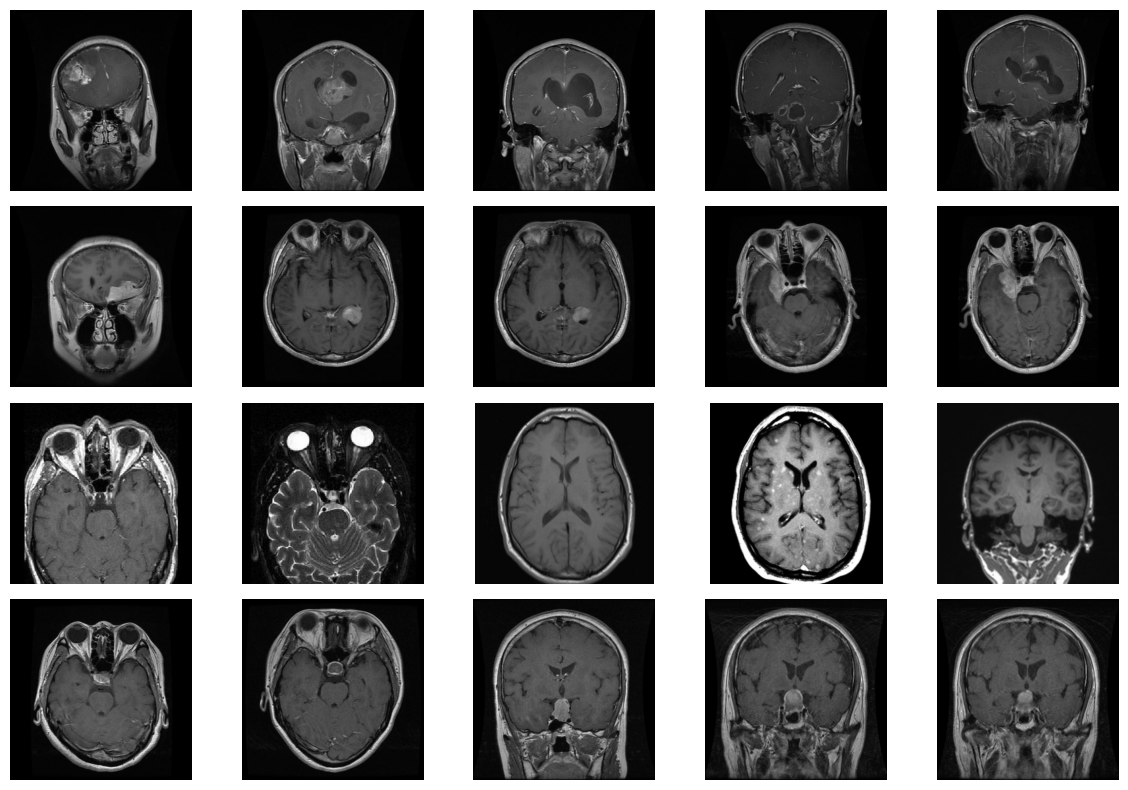

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(len(training_counts), 5, figsize=(12, 8))

for row, class_name in enumerate(training_counts.keys()):
    class_folder = os.path.join(training_path, class_name)
    image_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    for col, image_file in enumerate(image_files[:5]):
        image = mpimg.imread(os.path.join(class_folder, image_file))
        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(class_name, fontsize=10, rotation=0, labelpad=30)

plt.tight_layout()
plt.show()

## Data Cleanup

Before extracting features, it is important to confirm that the dataset is usable. We need to check that:

1. All images can be opened without errors.
2. There are no duplicate images across or within the training and testing sets.
3. Any issues are logged, and problematic files are removed before proceeding.

### Verify image readability

We attempt to open every image. If any cannot be read, we record its path and remove it from the dataset.

In [5]:
import csv

training_path = "../data/raw/Training"
testing_path = "../data/raw/Testing"
logs_directory = "../outputs/tables"
os.makedirs(logs_directory, exist_ok=True)

def verify_and_remove_images(split_path, log_file_path):
    unreadable_files = []
    for class_name in sorted(os.listdir(split_path)):
        class_folder = os.path.join(split_path, class_name)
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(class_folder, file_name)
                try:
                    Image.open(file_path).verify()
                except Exception:
                    unreadable_files.append(file_path)

    # Log unreadable files
    with open(log_file_path, "w", newline="", encoding="utf-8") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["file_path", "reason"])
        for file_path in unreadable_files:
            writer.writerow([file_path, "unreadable"])

    # Remove unreadable files
    removed_count = 0
    for file_path in unreadable_files:
        try:
            os.remove(file_path)
            removed_count += 1
        except FileNotFoundError:
            pass

    return unreadable_files, removed_count

unreadable_training_files, removed_training_count = verify_and_remove_images(
    training_path, os.path.join(logs_directory, "unreadable_training_files.csv")
)
unreadable_testing_files, removed_testing_count = verify_and_remove_images(
    testing_path, os.path.join(logs_directory, "unreadable_testing_files.csv")
)

print(f"Unreadable training images removed: {removed_training_count}")
print(f"Unreadable testing images removed: {removed_testing_count}")


Unreadable training images removed: 5712
Unreadable testing images removed: 1311


### Check for duplicates

We generate an MD5 hash per image. Files with the same hash are considered duplicates.
* If duplicates are found within the same category, we keep one copy and delete the rest.
* If duplicates are found across different categories in the same split, we cannot know which label is correct, so we delete all copies.
* All removals are logged to CSV.

In [6]:
import hashlib

training_path = "../data/raw/Training"
testing_path  = "../data/raw/Testing"
logs_directory = "../outputs/tables"
os.makedirs(logs_directory, exist_ok=True)

def calculate_md5_hash(file_path):
    with open(file_path, "rb") as file_stream:
        return hashlib.md5(file_stream.read()).hexdigest()

def list_image_paths(root_path):
    image_paths = []
    for class_name in sorted(os.listdir(root_path)):
        class_folder = os.path.join(root_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(class_folder, file_name))
    return sorted(image_paths)

def remove_within_split_duplicates(split_path, log_csv_path):
    image_paths = list_image_paths(split_path)
    hash_to_paths = {}
    for image_path in image_paths:
        file_hash = calculate_md5_hash(image_path)
        hash_to_paths.setdefault(file_hash, []).append(image_path)

    files_to_remove = []
    kept_files = []

    for file_hash, paths_with_same_hash in hash_to_paths.items():
        if len(paths_with_same_hash) <= 1:
            continue

        # Group paths by category name
        categories = {os.path.basename(os.path.dirname(p)) for p in paths_with_same_hash}

        if len(categories) > 1:
            # Same file in different categories → all are invalid
            files_to_remove.extend(paths_with_same_hash)
        else:
            # Same file duplicated within one category → keep 1, remove rest
            sorted_paths = sorted(paths_with_same_hash)
            keep_path = sorted_paths[0]
            remove_paths = sorted_paths[1:]
            kept_files.append(keep_path)
            files_to_remove.extend(remove_paths)

    # Log and remove
    with open(log_csv_path, "w", newline="", encoding="utf-8") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["file_path", "reason"])
        for file_path in sorted(set(files_to_remove)):
            csv_writer.writerow([
                file_path,
                "duplicate_across_categories" if file_path in files_to_remove and len({os.path.basename(os.path.dirname(p)) for p in hash_to_paths[calculate_md5_hash(file_path)]}) > 1
                else "duplicate_within_category"
            ])

    removed_count = 0
    for file_path in sorted(set(files_to_remove)):
        try:
            os.remove(file_path)
            removed_count += 1
        except FileNotFoundError:
            pass

    return removed_count

# Remove duplicates in Training
training_duplicates_log = os.path.join(logs_directory, "duplicate_files_removed_training.csv")
removed_training_duplicates = remove_within_split_duplicates(training_path, training_duplicates_log)

# Remove duplicates in Testing
testing_duplicates_log = os.path.join(logs_directory, "duplicate_files_removed_testing.csv")
removed_testing_duplicates = remove_within_split_duplicates(testing_path, testing_duplicates_log)

print(f"Training duplicates removed: {removed_training_duplicates} (logged to {training_duplicates_log})")
print(f"Testing duplicates removed: {removed_testing_duplicates} (logged to {testing_duplicates_log})")

Training duplicates removed: 0 (logged to ../outputs/tables\duplicate_files_removed_training.csv)
Testing duplicates removed: 0 (logged to ../outputs/tables\duplicate_files_removed_testing.csv)


### Re-count after clean up

Finally, we re-count how many images remain per class in both training and testing sets.

In [7]:
def count_images_per_class(split_path):
    counts = {}
    class_names = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    for class_name in class_names:
        class_folder = os.path.join(split_path, class_name)
        image_files = [
            file_name for file_name in os.listdir(class_folder)
            if file_name.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        counts[class_name] = len(image_files)
    return counts

training_counts_clean = count_images_per_class(training_path)
testing_counts_clean = count_images_per_class(testing_path)

print("Training image counts per class:", training_counts_clean)
print("Testing image counts per class:", testing_counts_clean)

Training image counts per class: {'glioma': 1321, 'meningioma': 1333, 'notumor': 1422, 'pituitary': 1445}
Testing image counts per class: {'glioma': 299, 'meningioma': 304, 'notumor': 381, 'pituitary': 300}


## 5. Reproducibility Controls - Ensuring Consistency

Before we preprocess or extract features, we lock down the environment. This makes results comparable and easier to debug. We will:

* Set global random seeds so splits and training are stable.
* Fix image size and HOG parameters in one place.
* Record library versions and all key parameters to a JSON file.
* Keep this metadata under `outputs/run_meta.json` for future runs.

In [8]:
import sys
import json
import random
import platform

import numpy as np
import matplotlib
import pandas as pd
import sklearn
import skimage

# Create outputs directory
outputs_directory = "../outputs"
os.makedirs(outputs_directory, exist_ok=True)

# Global seeds
random_seed = 42
os.environ["PYTHONHASHSEED"] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Image settings
image_height = 128
image_width = 128
image_channels = 1

# HOG parameters
hog_parameters = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys",
    "transform_sqrt": True
}

# Split settings
validation_fraction = 0.15
shuffle_before_split = True

# Paths
training_path = "../data/raw/Training"
testing_path = "../data/raw/Testing"

# Package versions and environment info
environment_info = {
    "python_version": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy_version": np.__version__,
    "pandas_version": pd.__version__,
    "matplotlib_version": matplotlib.__version__,
    "scikit_learn_version": sklearn.__version__,
    "scikit_image_version": skimage.__version__
}

# Collect run metadata
run_metadata = {
    "random_seed": random_seed,
    "image_settings": {
        "height": image_height,
        "width": image_width,
        "channels": image_channels
    },
    "hog_parameters": hog_parameters,
    "split_settings": {
        "validation_fraction": validation_fraction,
        "shuffle_before_split": shuffle_before_split
    },
    "paths": {
        "training_path": training_path,
        "testing_path": testing_path,
        "outputs_directory": outputs_directory
    },
    "environment": environment_info
}

# Save metadata
run_meta_path = os.path.join(outputs_directory, "run_meta.json")
with open(run_meta_path, "w", encoding="utf-8") as json_file:
    json.dump(run_metadata, json_file, indent=2)

print(f"Reproducibility metadata saved to: {run_meta_path}")
print("Seed initialised and parameters fixed.")

Reproducibility metadata saved to: ../outputs\run_meta.json
Seed initialised and parameters fixed.


## Preprocessing Pipeline - From images to consistent arrays

Goal: standardise every image so the model sees the same input shape and scale.

We will:

* Read each file safely.
* Convert to grayscale.
* Resize to the fixed shape we set earlier.
* Scale pixel values to `[0, 1]`.
* Build `X` (features) and `y` (labels) from the Training split.
* Save a small preview to confirm it worked.

### Helpers - load, standardise, and collect data



In [9]:
from typing import Tuple, List, Dict
from pathlib import Path

import numpy as np
from skimage import io, color, transform, util
from PIL import Image 

def resolve_dataset_path(candidates: List[str]) -> str:
    for candidate in candidates:
        path_obj = Path(candidate)
        if path_obj.exists() and path_obj.is_dir():
            return str(path_obj)
    return ""

training_path = resolve_dataset_path(["data/raw/Training", "../data/raw/Training"])
testing_path  = resolve_dataset_path(["data/raw/Testing",  "../data/raw/Testing"])

if not training_path or not testing_path:
    raise FileNotFoundError(
        "Could not find data/raw/Training or data/raw/Testing. "
        "If your notebook is at the repo root, use 'data/raw/...'."
    )

# image_height, image_width must exist
class_label_to_index: Dict[str, int] = {}

# Accept common image formats
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp")

def load_image_as_grayscale_resized(image_path: str,
                                    target_height: int,
                                    target_width: int) -> np.ndarray:
    """Read image, convert to grayscale (handles 1/3/4 channels), resize, scale to [0,1]."""
    try:
        image_array = io.imread(image_path)
    except Exception:
        image_array = np.array(Image.open(image_path).convert("RGB"))

    if image_array.ndim == 3:
        channels = image_array.shape[2]
        if channels == 4:
            image_array = color.rgba2rgb(image_array)
            image_array = color.rgb2gray(image_array)
        elif channels == 3:
            image_array = color.rgb2gray(image_array)
        else:
            image_array = np.array(Image.open(image_path).convert("L")) / 255.0
    elif image_array.ndim == 2:
        image_array = image_array.astype(np.float32)
        if image_array.max() > 1.0:
            image_array = image_array / 255.0
    else:
        image_array = np.array(Image.open(image_path).convert("L")) / 255.0

    image_array = util.img_as_float32(image_array)
    image_resized = transform.resize(
        image_array, (target_height, target_width),
        anti_aliasing=True, preserve_range=True
    ).astype(np.float32)

    return image_resized

def list_class_folders(root_path: str) -> List[str]:
    """Return sorted class folder names for reproducible label mapping."""
    return sorted([
        d for d in os.listdir(root_path)
        if os.path.isdir(os.path.join(root_path, d))
    ])

def build_dataset_arrays(root_path: str,
                         target_height: int,
                         target_width: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, int]]:
    """Create feature and label arrays from folder structure: root/class_name/*.(jpg|png|tif|bmp)."""
    if not Path(root_path).exists():
        raise FileNotFoundError(f"Root path not found: {root_path}")

    class_names = list_class_folders(root_path)
    if not class_names:
        raise ValueError(f"No class folders found under {root_path}")

    label_to_index = {name: idx for idx, name in enumerate(class_names)}

    feature_arrays: List[np.ndarray] = []
    label_indices: List[int] = []

    # Counters for visibility
    total_seen = 0
    total_loaded = 0

    for class_name in class_names:
        class_folder = os.path.join(root_path, class_name)
        image_file_names = [
            fn for fn in os.listdir(class_folder)
            if fn.lower().endswith(VALID_EXTENSIONS)
        ]
        if not image_file_names:
            raise ValueError(f"No images with {VALID_EXTENSIONS} in: {class_folder}")

        for image_file_name in image_file_names:
            total_seen += 1
            image_path = os.path.join(class_folder, image_file_name)
            try:
                image_resized = load_image_as_grayscale_resized(
                    image_path, target_height, target_width
                )
                feature_arrays.append(image_resized)
                label_indices.append(label_to_index[class_name])
                total_loaded += 1
            except Exception as error_message:
                print(f"Skipping {image_path}: {error_message}")

        print(f"Loaded {sum(1 for l in label_indices if l == label_to_index[class_name])} images for class '{class_name}'")

    if not feature_arrays:
        raise ValueError(
            f"No images could be loaded from {root_path}. "
            f"Checked extensions: {VALID_EXTENSIONS}. "
            f"Total seen: {total_seen}, total loaded: {total_loaded}."
        )

    features_array = np.stack(feature_arrays, axis=0)
    labels_array = np.array(label_indices, dtype=np.int64)

    return features_array, labels_array, label_to_index

# Build arrays for Training split
X_train_images, y_train, class_label_to_index = build_dataset_arrays(
    training_path, image_height, image_width
)

print("Training features shape (N, H, W):", X_train_images.shape)
print("Training labels shape (N,):", y_train.shape)
print("Class mapping:", class_label_to_index)

Loaded 1321 images for class 'glioma'
Loaded 1333 images for class 'meningioma'
Loaded 1422 images for class 'notumor'
Loaded 1445 images for class 'pituitary'
Training features shape (N, H, W): (5521, 128, 128)
Training labels shape (N,): (5521,)
Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### Visual Check - preprocessed samples

Show a small grid of preprocessed images to confirm two basics: the images are grayscale and the size is consistent.

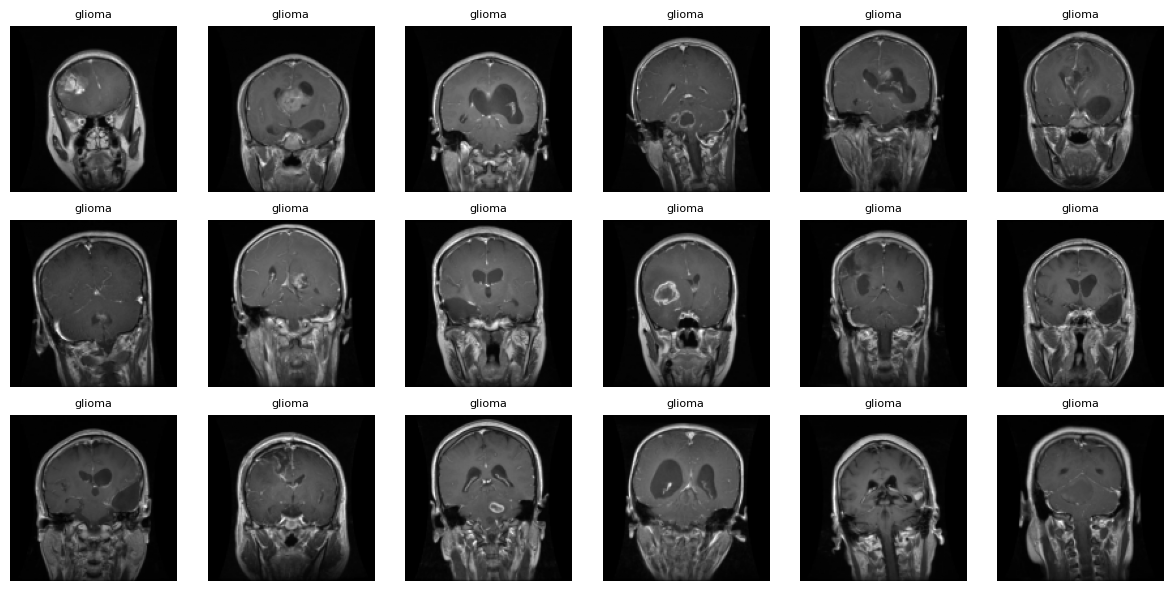

In [10]:
def plot_preprocessed_grid(images: np.ndarray,
                           labels: np.ndarray,
                           index_to_label: Dict[int, str],
                           rows: int = 3,
                           cols: int = 6) -> None:
    """Plot a grid of preprocessed images."""
    total = min(rows * cols, images.shape[0])
    plt.figure(figsize=(12, 6))
    for idx in range(total):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        plt.title(index_to_label[int(labels[idx])], fontsize=8)
    plt.tight_layout()
    plt.show()

index_to_label = {v: k for k, v in class_label_to_index.items()}
plot_preprocessed_grid(X_train_images, y_train, index_to_label)

## Feature Engineering - HOG features for classical ML

Before a classical machine learning model can learn from images, we need to turn each image into numbers that capture its structure. That step is called **feature engineering**. It is the process of choosing what information we present to the algorithm, and how.

Deep learning models learn features directly from raw pixels, but scikit-learn models expect fixed-length numeric vectors. So here, we design the features by hand. The goal is not to capture every detail of the MRI, but to provide a compact, structured description that still separates one class from another.

One of the most established techniques is **Histogram of Oriented Gradients (HOG)**. The idea is simple:

* Look at small regions of the image.
* Measure the direction of edges (for example, horizontal, vertical, diagonal).
* Count how often each direction appears.

Edges matter because they describe boundaries and shapes. If you imagine tracing outlines, HOG is recording where those outlines point. By tiling the image into blocks and collecting these “edge direction histograms,” we build a fixed-length vector for every image.

This vector is much smaller than the raw pixels, but still captures patterns that distinguish categories like **tumour vs notumor** or between different tumour types.

We will:

* Extract HOG vectors for each image using the parameters fixed in Step 5.
* Optionally standardise these vectors so each feature has similar scale.
* Optionally apply PCA to reduce dimensionality and visualise variance explained.

### Extract HOG features

In [11]:
from skimage.feature import hog

def extract_hog_features(images: np.ndarray,
                         hog_config: dict) -> np.ndarray:
    """Compute HOG for each image in a batch; returns N x D."""
    feature_list: List[np.ndarray] = []
    for image in images:
        hog_vector = hog(
            image,
            orientations=hog_config["orientations"],
            pixels_per_cell=hog_config["pixels_per_cell"],
            cells_per_block=hog_config["cells_per_block"],
            block_norm=hog_config["block_norm"],
            transform_sqrt=hog_config["transform_sqrt"],
            feature_vector=True
        )
        feature_list.append(hog_vector.astype(np.float32))
    return np.stack(feature_list, axis=0)

X_train_hog = extract_hog_features(X_train_images, hog_parameters)
print("HOG feature matrix shape (N, D):", X_train_hog.shape)

HOG feature matrix shape (N, D): (5521, 8100)


### Standardising features

Once we have HOG vectors, each feature dimension can have very different ranges. Some values might be very large, others very small. This imbalance can make the learning algorithm “pay more attention” to certain features just because of their scale, not because they are more important.

**Standardisation** solves this by centring the features around zero and scaling them so they all have roughly the same variance. This is like making sure every student in a class speaks at the same volume - otherwise the loudest one dominates the discussion.

For many algorithms in scikit-learn, especially Support Vector Machines, standardised features lead to better and more stable performance.

In [12]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler(with_mean=True, with_std=True)
X_train_hog_scaled = feature_scaler.fit_transform(X_train_hog)

print("Scaled HOG feature matrix shape:", X_train_hog_scaled.shape)

Scaled HOG feature matrix shape: (5521, 8100)


### Dimensionality reduction with PCA

HOG features can be very long - thousands of numbers per image. While the model can handle this, many of those numbers are correlated, which means there is redundancy.

**Principal Component Analysis (PCA)** is a method to compress the feature space while keeping most of the useful information. It works by finding new axes (principal components) that explain as much variance in the data as possible. In practice, PCA often lets us reduce thousands of features down to a few hundred, with very little loss in performance.

* This can speed up training,  reduce noise and allow us to *see* how much information is contained in fewer dimensions (by plotting explained variance).

We will keep enough components to explain 95% of the variance.

PCA-reduced shape: (5521, 1581)


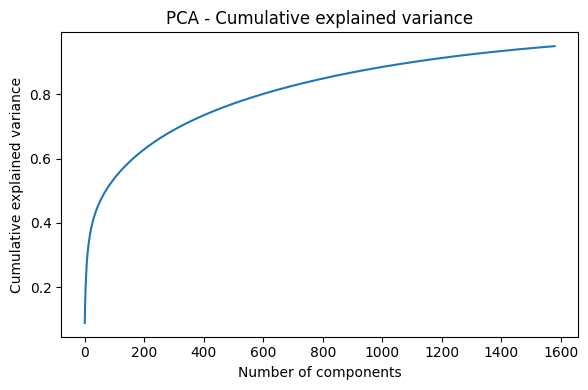

PCA explained variance plot saved to ../reports/figures/pca_explained_variance.png


In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Ensure figure output directory exists
os.makedirs("../reports/figures", exist_ok=True)

# Choose a variance target (e.g., keep 95% of variance)
pca_variance_target = 0.95
pca_transformer = PCA(
    n_components=pca_variance_target,
    svd_solver="full",
    random_state=random_seed
)
X_train_pca = pca_transformer.fit_transform(X_train_hog_scaled)

print("PCA-reduced shape:", X_train_pca.shape)

# Plot cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca_transformer.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA - Cumulative explained variance")
plt.tight_layout()

# Save to disk and also show inline
figure_path = "../reports/figures/pca_explained_variance.png"
plt.savefig(figure_path, dpi=300)
plt.show()

print(f"PCA explained variance plot saved to {figure_path}")


## Split Strategy - training, validation, and testing

**Split strategy** refers to how we divide the available data into different subsets that serve distinct roles in training a model. The dataset from Kaggle already comes with two folders: **Training** and **Testing**. The Testing set must stay untouched until the very end, so that it gives us an unbiased measure of final performance. But if we only had Training and Testing, we’d be forced to make model choices by peeking at the Testing set. That would contaminate the results.

To solve this, we create a third subset: the **Validation set**. This is carved out of the Training data and is used to tune models and hyperparameters. The Training subset is used to fit the model parameters, the Validation subset is used to compare approaches and detect overfitting, and the Testing set is held back until the final evaluation.

To make this reliable:

* We use a **stratified split**, which means each class is represented in the same proportions in both subsets.
* Any transformation that “learns” from the data - such as feature scaling or PCA dimensionality reduction - must be fit on the **training subset only**, then applied to the validation subset. This prevents information leakage.
* We check the class balance before and after the split, so we know the subsets reflect the full dataset fairly.

### Stratified split and non-leaky preprocessing

Train subset shape (N, D): (4416, 8100)
Validation subset shape (N, D): (1105, 8100)
Full training set class distribution


,class_index,count,proportion
0,0,1321,0.239268
1,1,1333,0.241442
2,2,1422,0.257562
3,3,1445,0.261728


Train subset class distribution


,class_index,count,proportion
0,0,1057,0.239357
1,1,1066,0.241395
2,2,1137,0.257473
3,3,1156,0.261775


Validation subset class distribution


,class_index,count,proportion
0,0,264,0.238914
1,1,267,0.241629
2,2,285,0.257919
3,3,289,0.261538


Scaled train subset shape: (4416, 8100)
Scaled validation subset shape: (1105, 8100)
PCA-reduced train subset shape: (4416, 1483)
PCA-reduced validation subset shape: (1105, 1483)


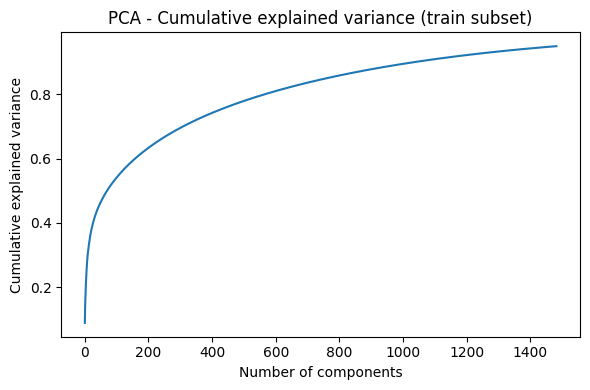

Saved PCA explained variance plot to ..\reports\figures\pca_explained_variance_train_subset.png
Saved PCA explained variance ratios to ../reports/metrics/pca_explained_variance_ratio.csv

Ready for modelling:
X_subtrain_features: (4416, 1483)
y_subtrain_labels  : (4416,)
X_validation_features: (1105, 1483)
y_validation_labels  : (1105,)
Saved split features to ../artifacts/features/train_val_features.npz
Saved scaler and PCA objects.
Saved run config and class mapping to ../reports/metrics/run_config.json


In [17]:
from sklearn.model_selection import train_test_split
from joblib import dump

# Ensure output folders exist at the repo root
Path("../reports/metrics").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)
Path("../artifacts/features").mkdir(parents=True, exist_ok=True)

def describe_and_save_class_distribution(labels_array: np.ndarray,
                                         title: str,
                                         csv_filename: str) -> pd.DataFrame:
    """Summarise class counts and proportions, save to CSV."""
    unique_classes, class_counts = np.unique(labels_array, return_counts=True)
    distribution_frame = pd.DataFrame({
        "class_index": unique_classes,
        "count": class_counts,
        "proportion": (class_counts / class_counts.sum()).round(6)
    })
    print(title)
    display(distribution_frame)
    distribution_frame.to_csv(Path("../reports/metrics") / csv_filename, index=False)
    return distribution_frame

# Perform stratified split on raw HOG features
validation_fraction = 0.20
(
    hog_features_train_subset,
    hog_features_validation_subset,
    labels_train_subset,
    labels_validation_subset,
) = train_test_split(
    X_train_hog,
    y_train,
    test_size=validation_fraction,
    stratify=y_train,
    random_state=random_seed,
    shuffle=True,
)

print("Train subset shape (N, D):", hog_features_train_subset.shape)
print("Validation subset shape (N, D):", hog_features_validation_subset.shape)

# Summarise and save class distributions
describe_and_save_class_distribution(y_train, "Full training set class distribution",
                                     "train_full_class_distribution.csv")
describe_and_save_class_distribution(labels_train_subset, "Train subset class distribution",
                                     "train_subset_class_distribution.csv")
describe_and_save_class_distribution(labels_validation_subset, "Validation subset class distribution",
                                     "validation_class_distribution.csv")

# Standardise features: fit on TRAIN subset only
feature_scaler_for_split = StandardScaler(with_mean=True, with_std=True)
hog_features_train_subset_scaled = feature_scaler_for_split.fit_transform(hog_features_train_subset)
hog_features_validation_subset_scaled = feature_scaler_for_split.transform(hog_features_validation_subset)

print("Scaled train subset shape:", hog_features_train_subset_scaled.shape)
print("Scaled validation subset shape:", hog_features_validation_subset_scaled.shape)

# Apply PCA: fit on TRAIN subset only
pca_transformer_for_split = PCA(
    n_components=pca_variance_target,
    svd_solver="full",
    random_state=random_seed
)
hog_features_train_subset_final = pca_transformer_for_split.fit_transform(hog_features_train_subset_scaled)
hog_features_validation_subset_final = pca_transformer_for_split.transform(hog_features_validation_subset_scaled)

print("PCA-reduced train subset shape:", hog_features_train_subset_final.shape)
print("PCA-reduced validation subset shape:", hog_features_validation_subset_final.shape)

# Save PCA explained variance curve
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca_transformer_for_split.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA - Cumulative explained variance (train subset)")
plt.tight_layout()
pca_figure_path = Path("../reports/figures") / "pca_explained_variance_train_subset.png"
plt.savefig(pca_figure_path, dpi=300)
plt.show()
print(f"Saved PCA explained variance plot to {pca_figure_path}")

# Save PCA explained variance ratios as CSV
pca_explained_variance_ratio_frame = pd.DataFrame(
    {"explained_variance_ratio": pca_transformer_for_split.explained_variance_ratio_}
)
pca_explained_variance_ratio_frame.to_csv("../reports/metrics/pca_explained_variance_ratio.csv", index=False)
print("Saved PCA explained variance ratios to ../reports/metrics/pca_explained_variance_ratio.csv")

# Prepare final variables for modelling
X_subtrain_features = hog_features_train_subset_final
y_subtrain_labels = labels_train_subset
X_validation_features = hog_features_validation_subset_final
y_validation_labels = labels_validation_subset

print("\nReady for modelling:")
print("X_subtrain_features:", X_subtrain_features.shape)
print("y_subtrain_labels  :", y_subtrain_labels.shape)
print("X_validation_features:", X_validation_features.shape)
print("y_validation_labels  :", y_validation_labels.shape)

# Save split features and labels for reproducibility
np.savez_compressed(
    "../artifacts/features/train_val_features.npz",
    X_subtrain_features=X_subtrain_features,
    y_subtrain_labels=y_subtrain_labels,
    X_validation_features=X_validation_features,
    y_validation_labels=y_validation_labels,
)
print("Saved split features to ../artifacts/features/train_val_features.npz")

# Persist transformers for reproducibility
dump(feature_scaler_for_split, Path("../reports/metrics") / "scaler_train_subset.joblib")
dump(pca_transformer_for_split, Path("../reports/metrics") / "pca_train_subset.joblib")
print("Saved scaler and PCA objects.")

# Save run configuration and class mapping
class_index_to_label = {int(index): label for label, index in class_label_to_index.items()}
run_config = {
    "random_seed": int(random_seed),
    "validation_fraction": validation_fraction,
    "pca_variance_target": float(pca_variance_target),
    "subtrain_shape": tuple(map(int, X_subtrain_features.shape)),
    "validation_shape": tuple(map(int, X_validation_features.shape)),
    "class_label_to_index": class_label_to_index,
    "class_index_to_label": class_index_to_label,
}
with open("../reports/metrics/run_config.json", "w", encoding="utf-8") as file_pointer:
    json.dump(run_config, file_pointer, indent=2)
print("Saved run config and class mapping to ../reports/metrics/run_config.json")


## Baselines - Support Vector Machines

In classical machine learning, a **baseline** means a model that sets the reference point for performance. It may not be the most advanced or complex approach, but it gives us a yardstick against which later models can be judged. Here, we will use **Support Vector Machines (SVMs)** - a family of algorithms well suited for classification tasks with high-dimensional data.

**What is an SVM?**
An SVM tries to find a boundary that separates classes in feature space. For our data, each MRI image has been reduced to a compact numerical representation (HOG features, with optional PCA). The SVM looks for the best separating surface between tumour types and the “no tumour” class. Two versions are worth testing:

* **Linear SVM** - assumes the classes can be separated by a straight hyperplane.
* **RBF SVM** - uses a radial basis kernel, allowing the boundary to bend and capture more complex patterns.

**Why do this?**
We want to know whether the signal in our data is simple (a linear boundary suffices) or requires a more flexible, nonlinear model. Comparing both gives us clarity on the complexity of the task. Whichever performs better on a held-out validation set becomes our chosen model for final testing.

We will:

* Train Linear and RBF SVMs on the sub-train split.
* Use a grid search to tune hyperparameters (`C`, and for RBF also `gamma`).
* Evaluate both on the validation set.
* Pick the winner based on **macro F1 score** (which balances performance across classes), with accuracy as a tie-breaker.
* Save the chosen model and all metrics for reproducibility.

Best Linear SVM parameters: {'C': 0.1}
Best RBF SVM parameters: {'C': 10.0, 'gamma': 'scale'}


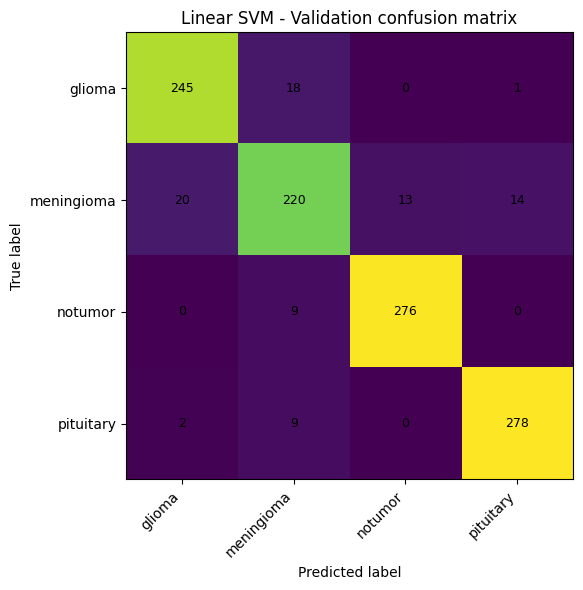

Linear SVM - validation accuracy: 0.9222, macro F1: 0.9203


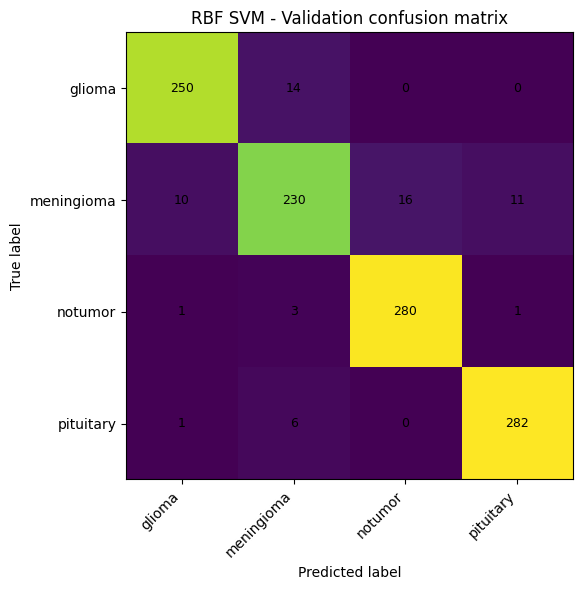

RBF SVM - validation accuracy: 0.9430, macro F1: 0.9416
Chosen model: RBF SVM
Saved best model to ..\artifacts\models\best_model.joblib
Saved validation selection summary to ../reports/metrics/validation_selection.json


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix

# Ensure output folders exist at the repo root
Path("../artifacts/models").mkdir(parents=True, exist_ok=True)
Path("../reports/metrics").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)
Path("../reports/predictions").mkdir(parents=True, exist_ok=True)

# Build readable label mapping
index_to_label_name = {int(index): label for label, index in class_label_to_index.items()}

def plot_and_save_confusion_matrix(true_labels: np.ndarray,
                                   predicted_labels: np.ndarray,
                                   figure_path: Path,
                                   title: str) -> None:
    """Draw and save a confusion matrix image to disk."""
    matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    tick_positions = np.arange(len(index_to_label_name))
    tick_names = [index_to_label_name[i] for i in tick_positions]
    plt.xticks(tick_positions, tick_names, rotation=45, ha="right")
    plt.yticks(tick_positions, tick_names)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, matrix[i, j], ha="center", va="center", fontsize=9)
    plt.tight_layout()
    plt.savefig(figure_path, dpi=300)
    plt.show()

def evaluate_on_validation(model_name: str,
                           estimator: SVC,
                           features_validation: np.ndarray,
                           labels_validation: np.ndarray,
                           predictions_csv_path: Path,
                           confusion_matrix_path: Path,
                           metrics_csv_path: Path) -> dict:
    """Compute metrics, save predictions and confusion matrix, return summary dict."""
    predicted_labels = estimator.predict(features_validation)
    accuracy = accuracy_score(labels_validation, predicted_labels)
    macro_f1 = f1_score(labels_validation, predicted_labels, average="macro")
    micro_f1 = f1_score(labels_validation, predicted_labels, average="micro")

    # Per-class precision, recall, f1, support
    precision, recall, f1, support = precision_recall_fscore_support(
        labels_validation, predicted_labels, average=None, zero_division=0
    )

    # Save predictions with human-readable labels
    predictions_frame = pd.DataFrame({
        "true_index": labels_validation,
        "true_label": [index_to_label_name[int(i)] for i in labels_validation],
        "pred_index": predicted_labels,
        "pred_label": [index_to_label_name[int(i)] for i in predicted_labels],
    })
    predictions_frame.to_csv(predictions_csv_path, index=False)

    # Save confusion matrix image
    plot_and_save_confusion_matrix(
        labels_validation, predicted_labels, confusion_matrix_path,
        f"{model_name} - Validation confusion matrix"
    )

    # Save metrics table
    per_class_rows = []
    for class_index in sorted(index_to_label_name.keys()):
        per_class_rows.append({
            "class_index": int(class_index),
            "class_label": index_to_label_name[class_index],
            "precision": float(precision[class_index]) if class_index < len(precision) else None,
            "recall": float(recall[class_index]) if class_index < len(recall) else None,
            "f1": float(f1[class_index]) if class_index < len(f1) else None,
            "support": int(support[class_index]) if class_index < len(support) else None,
        })
    metrics_summary = {
        "model_name": model_name,
        "accuracy": float(accuracy),
        "macro_f1": float(macro_f1),
        "micro_f1": float(micro_f1),
    }
    overall_row = pd.DataFrame([{
        "class_index": "ALL",
        "class_label": "ALL",
        **metrics_summary
    }])
    per_class_frame = pd.DataFrame(per_class_rows)
    metrics_frame = pd.concat([overall_row, per_class_frame], ignore_index=True)
    metrics_frame.to_csv(metrics_csv_path, index=False)

    print(f"{model_name} - validation accuracy: {accuracy:.4f}, macro F1: {macro_f1:.4f}")
    return metrics_summary

# Search spaces
linear_parameters = {
    "C": [0.1, 1.0, 10.0]
}
rbf_parameters = {
    "C": [0.1, 1.0, 10.0],
    "gamma": ["scale", 0.001, 0.01, 0.1]
}

# Stratified folds on the sub-train split
if "random_seed" not in globals():
    random_seed = 42
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

# Linear SVM (probability=True to enable later curves)
linear_svm = SVC(kernel="linear", class_weight="balanced", probability=True, random_state=random_seed)
linear_search = GridSearchCV(
    estimator=linear_svm,
    param_grid=linear_parameters,
    scoring="f1_macro",
    cv=inner_cv,
    n_jobs=-1,
    verbose=0
)
linear_search.fit(X_subtrain_features, y_subtrain_labels)
best_linear_svm = linear_search.best_estimator_
print("Best Linear SVM parameters:", linear_search.best_params_)

# RBF SVM
rbf_svm = SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=random_seed)
rbf_search = GridSearchCV(
    estimator=rbf_svm,
    param_grid=rbf_parameters,
    scoring="f1_macro",
    cv=inner_cv,
    n_jobs=-1,
    verbose=0
)
rbf_search.fit(X_subtrain_features, y_subtrain_labels)
best_rbf_svm = rbf_search.best_estimator_
print("Best RBF SVM parameters:", rbf_search.best_params_)

# Evaluate both on validation split
linear_validation_metrics = evaluate_on_validation(
    model_name="Linear SVM",
    estimator=best_linear_svm,
    features_validation=X_validation_features,
    labels_validation=y_validation_labels,
    predictions_csv_path=Path("../reports/predictions/validation_predictions_linear.csv"),
    confusion_matrix_path=Path("../reports/figures/validation_confusion_matrix_linear.png"),
    metrics_csv_path=Path("../reports/metrics/validation_metrics_linear.csv"),
)

rbf_validation_metrics = evaluate_on_validation(
    model_name="RBF SVM",
    estimator=best_rbf_svm,
    features_validation=X_validation_features,
    labels_validation=y_validation_labels,
    predictions_csv_path=Path("../reports/predictions/validation_predictions_rbf.csv"),
    confusion_matrix_path=Path("../reports/figures/validation_confusion_matrix_rbf.png"),
    metrics_csv_path=Path("../reports/metrics/validation_metrics_rbf.csv"),
)

# Pick winner by macro F1 (tie-break with accuracy)
def pick_winner(metrics_a: dict, model_a_name: str,
                metrics_b: dict, model_b_name: str) -> str:
    """Return the chosen model name based on macro F1, then accuracy."""
    if abs(metrics_a["macro_f1"] - metrics_b["macro_f1"]) > 1e-12:
        return model_a_name if metrics_a["macro_f1"] > metrics_b["macro_f1"] else model_b_name
    return model_a_name if metrics_a["accuracy"] > metrics_b["accuracy"] else model_b_name

chosen_model_name = pick_winner(
    linear_validation_metrics, "Linear SVM",
    rbf_validation_metrics, "RBF SVM"
)
chosen_estimator = best_linear_svm if chosen_model_name == "Linear SVM" else best_rbf_svm
print(f"Chosen model: {chosen_model_name}")

# Save the chosen model and a small manifest
chosen_model_path = Path("../artifacts/models/best_model.joblib")
dump(chosen_estimator, chosen_model_path)
print(f"Saved best model to {chosen_model_path}")

validation_manifest = {
    "chosen_model": chosen_model_name,
    "linear_search_best_params": linear_search.best_params_,
    "rbf_search_best_params": rbf_search.best_params_,
    "linear_validation_metrics": linear_validation_metrics,
    "rbf_validation_metrics": rbf_validation_metrics,
}
with open(Path("../reports/metrics/validation_selection.json"), "w", encoding="utf-8") as file_pointer:
    json.dump(validation_manifest, file_pointer, indent=2)
print("Saved validation selection summary to ../reports/metrics/validation_selection.json")


## Evaluation

In this step we take the full pipeline - preprocessing, HOG features, scaling, PCA, and the chosen model - and apply it to the Testing split, which has been kept separate from training. Running on completely unseen data gives us a realistic measure of generalisation. The metrics we record here, including accuracy, F1 scores, and confusion matrices, form the final report card of the model.

Loaded 299 images for class 'glioma'
Loaded 304 images for class 'meningioma'
Loaded 381 images for class 'notumor'
Loaded 300 images for class 'pituitary'
Testing images shape (N, H, W): (1284, 128, 128)
Testing labels shape (N,): (1284,)
Testing HOG feature matrix shape (N, D): (1284, 8100)
Loaded scaler and PCA from: ../reports/metrics/scaler_train_subset.joblib and ../reports/metrics/pca_train_subset.joblib
Final test feature matrix shape (N, D): (1284, 1483)
Loaded chosen model from: ../artifacts/models/best_model.joblib
Test accuracy: 0.9517 | Test macro F1: 0.9496 | Test micro F1: 0.9517
Saved test metrics to ..\reports\metrics\test_metrics.csv
Saved test predictions to ..\reports\predictions\test_predictions.csv


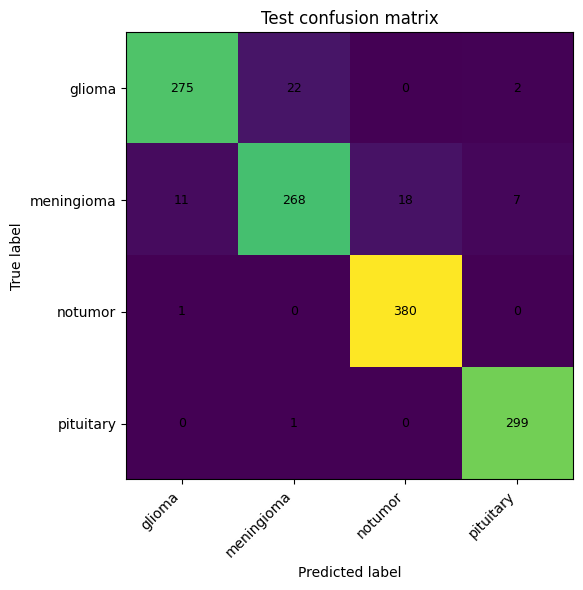

Saved test confusion matrix to ..\reports\figures\test_confusion_matrix.png
Saved test evaluation summary to ../reports/metrics/test_evaluation_summary.json


In [19]:
from joblib import load

# Ensure output folders exist at the repo root
Path("../reports/metrics").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)
Path("../reports/predictions").mkdir(parents=True, exist_ok=True)

# Load Testing images and labels from disk
testing_root_path = "../data/raw/Testing"
X_test_images, y_test_raw_indices, test_label_to_index_local = build_dataset_arrays(
    testing_root_path, image_height, image_width
)

# Align test labels to the training mapping
# - Build inverse mapping from training indices to labels
index_to_label_training = {int(index): label for label, index in class_label_to_index.items()}
# - Map local test indices to labels, then back to training indices
test_labels_as_names = [list(test_label_to_index_local.keys())[list(test_label_to_index_local.values()).index(i)]
                        for i in y_test_raw_indices]
y_test = np.array([class_label_to_index[label_name] for label_name in test_labels_as_names], dtype=np.int64)

print("Testing images shape (N, H, W):", X_test_images.shape)
print("Testing labels shape (N,):", y_test.shape)

# Extract HOG features with the same configuration used for training
X_test_hog = extract_hog_features(X_test_images, hog_parameters)
print("Testing HOG feature matrix shape (N, D):", X_test_hog.shape)

# Load frozen transformers from Step 8
scaler_path = "../reports/metrics/scaler_train_subset.joblib"
pca_path = "../reports/metrics/pca_train_subset.joblib"
feature_scaler_loaded = load(scaler_path)
pca_transformer_loaded = load(pca_path)
print("Loaded scaler and PCA from:", scaler_path, "and", pca_path)

# Transform test features with the frozen scaler and PCA
X_test_hog_scaled = feature_scaler_loaded.transform(X_test_hog)
X_test_features_final = pca_transformer_loaded.transform(X_test_hog_scaled)
print("Final test feature matrix shape (N, D):", X_test_features_final.shape)

# Load the chosen baseline model from Step 9
chosen_model_path = "../artifacts/models/best_model.joblib"
chosen_estimator_loaded = load(chosen_model_path)
print("Loaded chosen model from:", chosen_model_path)

# Predict labels and, if available, probabilities
y_test_pred = chosen_estimator_loaded.predict(X_test_features_final)
y_test_proba = None
if hasattr(chosen_estimator_loaded, "predict_proba"):
    y_test_proba = chosen_estimator_loaded.predict_proba(X_test_features_final)

# Compute overall metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_macro_f1 = f1_score(y_test, y_test_pred, average="macro")
test_micro_f1 = f1_score(y_test, y_test_pred, average="micro")
print(f"Test accuracy: {test_accuracy:.4f} | Test macro F1: {test_macro_f1:.4f} | Test micro F1: {test_micro_f1:.4f}")

# Compute per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_test_pred, average=None, zero_division=0
)

# Save per-class and overall metrics
index_to_label_name = {int(index): label for label, index in class_label_to_index.items()}
per_class_rows = []
for class_index in sorted(index_to_label_name.keys()):
    per_class_rows.append({
        "class_index": int(class_index),
        "class_label": index_to_label_name[class_index],
        "precision": float(precision_per_class[class_index]) if class_index < len(precision_per_class) else None,
        "recall": float(recall_per_class[class_index]) if class_index < len(recall_per_class) else None,
        "f1": float(f1_per_class[class_index]) if class_index < len(f1_per_class) else None,
        "support": int(support_per_class[class_index]) if class_index < len(support_per_class) else None,
    })

overall_summary_row = pd.DataFrame([{
    "class_index": "ALL",
    "class_label": "ALL",
    "accuracy": float(test_accuracy),
    "macro_f1": float(test_macro_f1),
    "micro_f1": float(test_micro_f1),
}])

per_class_frame = pd.DataFrame(per_class_rows)
test_metrics_frame = pd.concat([overall_summary_row, per_class_frame], ignore_index=True)
test_metrics_csv_path = Path("../reports/metrics/test_metrics.csv")
test_metrics_frame.to_csv(test_metrics_csv_path, index=False)
print(f"Saved test metrics to {test_metrics_csv_path}")

# Save predictions with readable labels and probabilities
test_predictions_frame = pd.DataFrame({
    "true_index": y_test,
    "true_label": [index_to_label_name[int(i)] for i in y_test],
    "pred_index": y_test_pred,
    "pred_label": [index_to_label_name[int(i)] for i in y_test_pred],
})
# Add probability columns if available
if y_test_proba is not None:
    for class_index in sorted(index_to_label_name.keys()):
        column_name = f"proba_{index_to_label_name[class_index]}"
        test_predictions_frame[column_name] = y_test_proba[:, class_index]

test_predictions_csv_path = Path("../reports/predictions/test_predictions.csv")
test_predictions_frame.to_csv(test_predictions_csv_path, index=False)
print(f"Saved test predictions to {test_predictions_csv_path}")

# Plot and save the confusion matrix
def plot_and_save_confusion_matrix(true_labels: np.ndarray,
                                   predicted_labels: np.ndarray,
                                   class_index_to_label: dict,
                                   figure_path: Path,
                                   title: str) -> None:
    """Draw and save a confusion matrix image to disk."""
    matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    plt.imshow(matrix, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    tick_positions = np.arange(len(class_index_to_label))
    tick_names = [class_index_to_label[i] for i in tick_positions]
    plt.xticks(tick_positions, tick_names, rotation=45, ha="right")
    plt.yticks(tick_positions, tick_names)
    for row_index in range(matrix.shape[0]):
        for col_index in range(matrix.shape[1]):
            plt.text(col_index, row_index, matrix[row_index, col_index],
                     ha="center", va="center", fontsize=9)
    plt.tight_layout()
    plt.savefig(figure_path, dpi=300)
    plt.show()

test_confusion_matrix_path = Path("../reports/figures/test_confusion_matrix.png")
plot_and_save_confusion_matrix(
    y_test, y_test_pred, index_to_label_name,
    test_confusion_matrix_path,
    "Test confusion matrix"
)
print(f"Saved test confusion matrix to {test_confusion_matrix_path}")

# Save a compact manifest of this evaluation
test_eval_manifest = {
    "chosen_model_path": str(chosen_model_path),
    "scaler_path": str(scaler_path),
    "pca_path": str(pca_path),
    "test_accuracy": float(test_accuracy),
    "test_macro_f1": float(test_macro_f1),
    "test_micro_f1": float(test_micro_f1),
    "num_test_samples": int(len(y_test)),
}
with open(Path("../reports/metrics/test_evaluation_summary.json"), "w", encoding="utf-8") as file_pointer:
    json.dump(test_eval_manifest, file_pointer, indent=2)
print("Saved test evaluation summary to ../reports/metrics/test_evaluation_summary.json")

## Error analysis

High overall accuracy does not mean the model is without weaknesses. Error analysis is the process of looking closely at the mistakes: not just their number, but their nature. For this problem, the type of mistake matters. Misclassifying one tumour as another is different from misclassifying a tumour as “no tumour,” and each carries its own implications.

By examining misclassified images and breaking down errors per class, we can see the specific blind spots of the system. This gives us a more complete picture of its behaviour and sets the stage for discussing both technical limitations and ethical considerations.

Total misclassifications: 62
Saved error summary to ..\reports\metrics\error_summary.csv
Saved detailed error counts to ..\reports\metrics\error_counts_by_class.csv


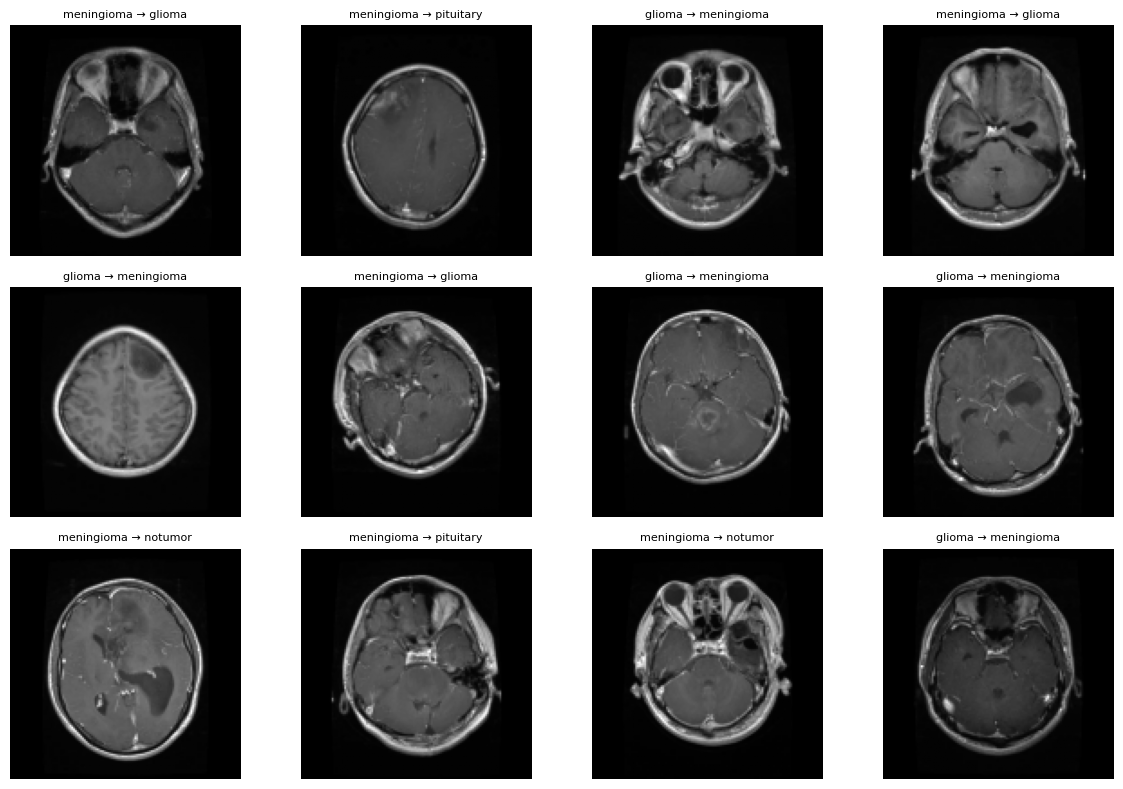

Saved misclassified examples grid to ..\reports\figures\misclassified_grid.png


In [20]:
# Ensure output folders exist
Path("../reports/metrics").mkdir(parents=True, exist_ok=True)
Path("../reports/figures").mkdir(parents=True, exist_ok=True)

# Load test predictions if not already in memory
test_predictions_csv_path = Path("../reports/predictions/test_predictions.csv")
test_predictions_frame = pd.read_csv(test_predictions_csv_path)

# Identify misclassifications
misclassified = test_predictions_frame[
    test_predictions_frame["true_index"] != test_predictions_frame["pred_index"]
]
print(f"Total misclassifications: {len(misclassified)}")

# Save error summary as CSV
error_summary_csv_path = Path("../reports/metrics/error_summary.csv")
misclassified.to_csv(error_summary_csv_path, index=False)
print(f"Saved error summary to {error_summary_csv_path}")

# Count mistakes per true class
error_counts = (
    misclassified.groupby("true_label")["pred_label"]
    .value_counts()
    .rename("count")
    .reset_index()
)
error_counts_csv_path = Path("../reports/metrics/error_counts_by_class.csv")
error_counts.to_csv(error_counts_csv_path, index=False)
print(f"Saved detailed error counts to {error_counts_csv_path}")

# Visualise a grid of misclassified examples
def plot_misclassified_examples(misclassified_frame: pd.DataFrame,
                                num_examples: int = 12) -> None:
    """Show a grid of misclassified test images with true -> predicted labels."""
    sample = misclassified_frame.sample(min(num_examples, len(misclassified_frame)), random_state=random_seed)
    plt.figure(figsize=(12, 8))
    for idx, row in enumerate(sample.itertuples(), 1):
        plt.subplot(3, 4, idx)
        plt.imshow(X_test_images[idx], cmap="gray")
        plt.axis("off")
        plt.title(f"{row.true_label} → {row.pred_label}", fontsize=8)
    plt.tight_layout()
    figure_path = Path("../reports/figures/misclassified_grid.png")
    plt.savefig(figure_path, dpi=300)
    plt.show()
    print(f"Saved misclassified examples grid to {figure_path}")

plot_misclassified_examples(misclassified, num_examples=12)

## Conclusion

We began with raw MRI scans and walked them through a full classical machine learning pipeline. Each step served a specific purpose: cleaning and checking the data for integrity, reducing the images to consistent grayscale arrays, extracting structured features through HOG, and applying scaling and PCA to make the feature space more manageable. From there we trained linear and nonlinear SVMs, validated them, and finally tested the chosen model on data it had never seen.

The results were substantial - over 95% accuracy on the test split with fewer than 5% misclassifications. Error analysis showed where the model’s blind spots lie, reminding us that high performance numbers never remove the need for caution. Especially in medical contexts, mistakes carry different weights depending on the type of error.

What this gives us is a clear baseline. A reproducible starting point that demonstrates how far classical methods can take us and where their limits begin. From here, more advanced approaches - such as deep learning with convolutional neural networks - can build on this foundation, often capturing patterns that HOG and SVM cannot.

The key takeaway is the process: careful preprocessing, rigorous validation, transparent evaluation, and error analysis.